In [115]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
# import xlrd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
warnings.filterwarnings('ignore')

In [116]:
# Load updated shorage database
df = pd.read_csv("Shortage data/shortage_final.csv")

# converting headers in lowercase
df.columns = df.columns.str.lower()

# replacing spaces for "_" in headers
df.columns = df.columns.str.replace(' ', '_')

# Removing NaN actual_start_date and actual_end_date, considering as an incomplete record
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

# Removing Actuals before 2017
df = df.loc[(df['actual_start_date'] >= '2017-01-01')]
# Removing outliers before 2010 for End_date
df = df.loc[(df['actual_end_date'] >= '2010-01-01')]

# Removing duplicates ID Reports
df=df.drop_duplicates("report_id", keep=False)

# Removing Avoided shortages (outliers for our analysis)
df = df[df['shortage_status']!="Avoided shortage"]

df.tail()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,atc_code,atc_description,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3
17163,21685,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,na,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2017-09-08,2017-09-22,2017-09-22,Other (Please describe in comments),2017-09-08,2017-09-25,No
17164,52702,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,7.5g pump,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2019-04-01,NaN,2019-07-12,Other (Please describe in comments),2018-06-20,2019-07-13,No
17165,18241,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,1 mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2017-08-03,2017-08-03,2017-09-18,2017-10-06,Disruption of the manufacture of the drug.,2017-08-03,2017-10-13,No
17166,33440,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,5mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2019-09-16,2019-09-16,2019-09-20,2019-09-18,Disruption of the manufacture of the drug.,2017-12-18,2019-09-19,No
17167,54338,2243686.0,Shortage,ZYVOXAM,PFIZER CANADA INC,Zyvoxam,LINEZOLID,3G,1x240ml Btl,ORAL,...,J01XX,OTHER ANTIBACTERIALS,NaN,2018-08-21,NaN,2018-10-23,Disruption of the manufacture of the drug.,2018-07-04,2018-10-24,No


In [117]:
# converting into datatime critical field
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

In [118]:
# Fill null DIN with zero, convering into integer
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')

In [119]:
# Removing duplicates reports
df=df.drop_duplicates("report_id", keep=False)

In [120]:
# calculating # of days of shortages
df['Days']= df['actual_end_date']-df['actual_start_date']

In [121]:
# Create clear field number of days as integer
df['Days2'] = df['Days'].dt.days
df['Days2']=df['Days2'].astype('int')

In [122]:
# Removing negative days
df= df[(df['Days2']>=0)]
df.Days2.min()

0

In [123]:
print ("Unique values:  \n",df.nunique())

Unique values:  
 report_id                     13476
drug_identification_number     5475
report_type                       1
brand_name                     3438
company_name                    196
common_or_proper_name          4581
ingredients                    1174
strength(s)                     871
packaging_size                 2424
route_of_administration         177
shortage_status                   2
dosage_form(s)                  121
atc_code                        463
atc_description                 201
anticipated_start_date         1257
actual_start_date              1706
estimated_end_date             1602
actual_end_date                1677
reason                            7
date_created                   1518
date_updated                   1802
tier_3                            2
Days                            817
Days2                           817
dtype: int64


<AxesSubplot:xlabel='shortage_status', ylabel='Days2'>

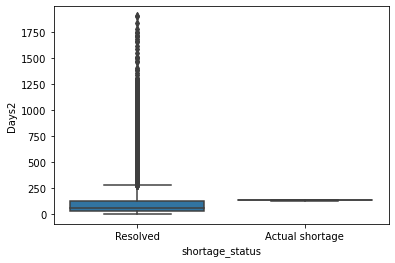

In [124]:
sns.boxplot(data = df,
                x =df['shortage_status'],
                y = df['Days2'])

In [125]:
df2=df.groupby(["common_or_proper_name"])["Days2"].sum().reset_index(name="Days").sort_values(by="Days",ascending=False).head(10)
df2

,common_or_proper_name,Days
4132,VALSARTAN,17891
3358,SIMVASTATIN,17071
1998,LOSARTAN,16009
621,CANDESARTAN,15937
3155,ROSUVASTATIN,13977
1052,DILTIAZEM,13518
2570,OLANZAPINE,13052
3127,RISPERIDONE ODT,12676
1749,IRBESARTAN,11928
3168,Ramipril,11905


In [126]:
# store the very first on the list with more # of days
df2=df.groupby(["common_or_proper_name"])["Days2"].sum().reset_index(name="Days").sort_values(by="Days",ascending=False).head(1)


In [127]:
list_a= df2['common_or_proper_name'].unique().tolist()
# list_a=list_a[-1]
list_a

['VALSARTAN']

In [128]:
df= df[df['common_or_proper_name'].isin(list_a)]
df.head()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3,Days,Days2
1887,163203,2414201,Shortage,AURO-VALSARTAN,AURO PHARMA INC,VALSARTAN,VALSARTAN,40MG,100's,ORAL\r\nORAL,...,NaN,2022-06-20,2022-10-10,2022-10-10,Demand increase for the drug.,2022-06-21,2022-10-24,No,112 days,112
5763,181733,2356767,Shortage,SANDOZ VALSARTAN,SANDOZ CANADA INCORPORATED,VALSARTAN,VALSARTAN,160MG,500FCT,ORAL\r\nORAL,...,NaN,2023-01-18,2023-02-10,2023-02-08,Delay in shipping of the drug.,2023-01-19,2023-02-09,No,21 days,21
6377,143582,2363100,Shortage,TARO-VALSARTAN,SUN PHARMA CANADA INC,VALSARTAN,VALSARTAN,80MG,100,ORAL\r\nORAL,...,NaN,2021-08-01,2021-08-06,2021-08-06,Disruption of the manufacture of the drug.,2021-08-04,2021-08-24,No,5 days,5
6378,143590,2363119,Shortage,TARO-VALSARTAN,SUN PHARMA CANADA INC,VALSARTAN,VALSARTAN,160MG,500,ORAL\r\nORAL,...,NaN,2021-08-01,NaN,2021-11-26,Disruption of the manufacture of the drug.,2021-08-04,2021-11-27,No,117 days,117
7818,114752,2366975,Shortage,VALSARTAN,SANIS HEALTH INC,VALSARTAN,VALSARTAN,320MG,100,ORAL\r\nORAL,...,NaN,2020-05-11,2020-07-16,2020-08-04,Disruption of the manufacture of the drug.,2020-05-11,2020-08-05,No,85 days,85


array([[<AxesSubplot:title={'center':'Days2'}>]], dtype=object)

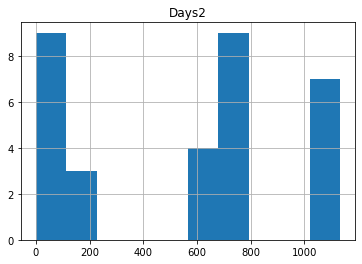

In [129]:
df.hist(column='Days2')

<AxesSubplot:xlabel='actual_start_date', ylabel='Days2'>

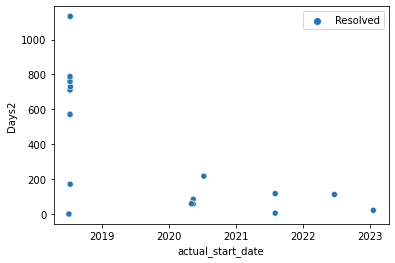

In [130]:
# Create a scatter plot of time and # of Days
sns.scatterplot(data = df, x =df['actual_start_date'],
                               y = df['Days2'],
                               hue=df.shortage_status.tolist())

In [138]:
df.Days2.max()

1133

<AxesSubplot:title={'center':'Days Distribution'}, ylabel='# of Days'>

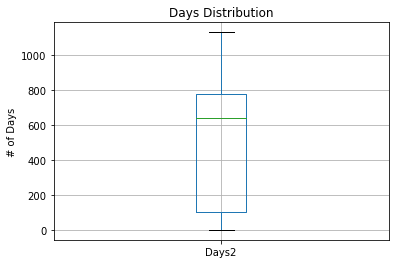

In [134]:
# Create a box plot to identify outliers

Boxplot, bp=plt.subplots()
# bp.set_xlabel('Days')
bp.set_ylabel('# of Days')
bp.set_title('Days Distribution')
bp.grid()
df.boxplot(column="Days2", showfliers=False)

In [139]:
col_list = ['actual_start_date', 'Days2']

In [140]:
df = df[col_list]

In [141]:
df.columns = ['ds', 'y']

In [142]:
df.shape

(32, 2)

### 1 year Forecasting using Prophet

In [143]:
m = Prophet()
m.fit(df)


23:59:00 - cmdstanpy - INFO - Chain [1] start processing
23:59:00 - cmdstanpy - INFO - Chain [1] done processing


In [144]:
future = m.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
370,2024-01-14
371,2024-01-15
372,2024-01-16
373,2024-01-17
374,2024-01-18


In [145]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
370,2024-01-14,-159.359392,-377.985186,45.122964
371,2024-01-15,234.113251,13.232490,436.589083
372,2024-01-16,400.990000,195.052246,624.122204
373,2024-01-17,-33.931785,-243.989722,207.592910
374,2024-01-18,15.146959,-193.674863,226.410063


Text(45.125, 0.5, 'Days of Shortage')

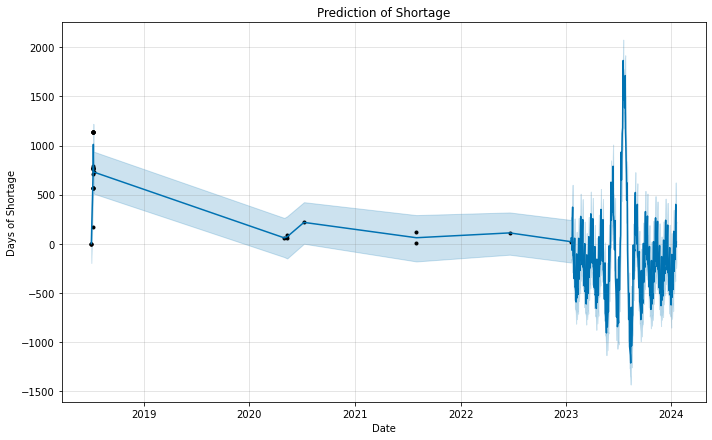

In [146]:
fig1 = m.plot(forecast)
plt.title("Prediction of Shortage")
plt.xlabel("Date")
plt.ylabel("Days of Shortage")

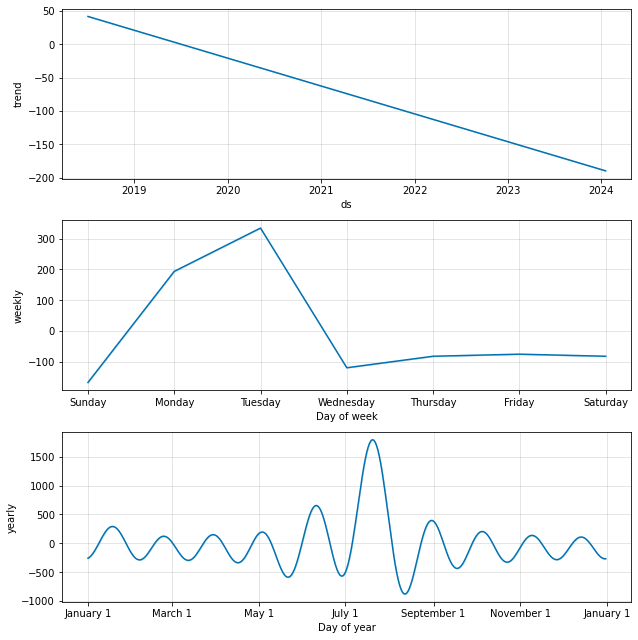

In [147]:
fig2 = m.plot_components(forecast)

Zoom in into predicted values

In [148]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)